Logs
- [2023/05/13]     
  First version of this notebook.    
  Update `add_prediction_table` function

# Example 7.8 - Forecast Seasonal Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.stats as sc_stats
import tabulate

from sklearn.linear_model import LinearRegression

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`

In [4]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  elif isinstance(column, list):
    df = pd.read_excel(filename, engine="odf", header=0, usecols=columns)
  else:
    key_arr = {k for k in columns.keys()}
    df = pd.read_excel(filename, engine="odf", header=0, usecols=key_arr)
    df = pd.rename(columns=columns)
  return df

### Get multiple regression coefficients

In [23]:
def get_multiple_regress_coeff(df, n_vars=2, with_intercept=True):  

  regress_obj = LinearRegression(fit_intercept=with_intercept)

  if isinstance(df, pd.DataFrame):
    num_of_samples = len(df)
    X_arr = np.zeros((num_of_samples, n_vars))
    Y = df["Y"].to_numpy()

    for i in range(n_vars):
      key = f"X_{i+1}"
      X_arr[:, i] = df[key].to_numpy()

    regress = regress_obj.fit(X_arr, Y)
    df["hat_Y"] = regress.intercept_ + X_arr.dot(regress.coef_) 
  
  elif isinstance(df, np.ndarray):
    Y = df[:, 0]
    X_arr = df[:, 1:]

    
    regress = regress_obj.fit(X_arr, Y)
    Y_hat = regress.intercept_ + X_arr.dot(regress.coef_)
    df = np.column_stack([df, Y_hat])

  return regress, df


### Get Minitab output of Regression Analysis

In [170]:
def add_prediction_table(regress, x_regress_arr, df, n_vars, cofactor_matrix, 
                          significance_lvl=0.05):
  n_data = len(df)

  b0 = regress.intercept_
  b_arr = regress.coef_

  hat_Y = b0
  for i in range(n_vars):
    hat_Y += b_arr[i]*df_minitab[f"X_{i+1}"]

  
  data = [[]]
  fit = []
  prediction_interval = []
  for i, x_regress in enumerate(x_regress_arr):
    # display(cofactor_matrix) 
    X0_vector = np.ones(n_vars + 1)
    X0_vector[1:] = x_regress

    sumOfSquareY_of_hat_Y = ((df["Y"] - hat_Y)**2).sum()
    std_yx = np.sqrt(sumOfSquareY_of_hat_Y/(n_data - n_vars - 1))

    # -- for confidence interval (CI) and minitab S.E. of fit
    #    This measure the dispersion of the sample regression line
    #    about the population regression line
    #    The formula for multiple regression follow (Desalvo, 1971)
    std_err_fit = std_yx * np.sqrt(
      X0_vector.transpose().dot(cofactor_matrix).dot(X0_vector))
    std_forecast = std_yx * np.sqrt(
      1 + X0_vector.transpose().dot(cofactor_matrix).dot(X0_vector))
    # print(f"std_forecast: {std_forecast}")

    # -- 95% CI and 95% PI are computed using t-statistic although
    #    n_data > 30
    deg_of_freedom = n_data - n_vars - 1
    l_bound = sc_stats.t.ppf(significance_lvl/2, deg_of_freedom)
    u_bound = sc_stats.t.ppf(1 - significance_lvl/2, deg_of_freedom)


    Y_t = b0
    for i in range(n_vars):
      Y_t += b_arr[i]*x_regress[i]

    fit.append(Y_t)
    prediction_interval.append([Y_t + l_bound * std_forecast, Y_t + u_bound * std_forecast])
    data.append([
      i+1, Y_t, std_err_fit, 
      f"({Y_t + l_bound * std_err_fit:.3f}, {Y_t + u_bound * std_err_fit:.3f})",
      f"({Y_t + l_bound * std_forecast:.3f}, {Y_t + u_bound * std_forecast:.3f})"])

  table_prediction = tabulate.tabulate(data, tablefmt='html', 
    headers=["New Obs", "Fit", "SE Fit", "95% CI", "95% PI"],
    floatfmt=[int, ".3f", ".3f", str, str])

  print(f"Predicted Values for New Observations")
  display(table_prediction)

  return fit, prediction_interval

In [150]:
def add_predictor_table(x_regress_arr, new_column):
  data = [[]]
  for x_regress in x_regress_arr:
    data.append([1, *x_regress])


  table_predictor = tabulate.tabulate(data, tablefmt="html",
    headers=["New Obs", *new_column[1:]], 
    floatfmt=[int, ".1f", int, int, int])

  print(f"Values of Predictors for New Observations")
  display(table_predictor)

#### Minitab output

In [171]:
def get_minitab_out(df, n_vars=2, new_column=None, withCorrMatrix=False, 
  withVIF=False, with_intercept=True, with_DW_stat=True, is_reg_diff=False,
  new_observ=0, x_regress=None):

  """
  new_column (dict) : a dictionary mapping to rename df header
  is_reg_diff:
    True - if we perform regression difference of Y_t and X_t. 
    In this function, it only implements how to print the output not the
    calculation
  new_observ: int
    Number of forecasting point.
  """
  
  data_struct = np.zeros((len(df), 1+n_vars))
  data_struct[:, 0] = df['Y']
  for i in range(n_vars):
    key = f"X_{i+1}"
    data_struct[:, i+1] = df[key]

  # -- compute correlation matrix
  corr_matrix = np.corrcoef(data_struct, rowvar=False)
  corr_matrix = corr_matrix[1:, 0:-1]    # only show lower triangle part of correlation matrix

  # -- compute regression intercept and coefficients
  regress, _ = get_multiple_regress_coeff(df, n_vars=n_vars, with_intercept=with_intercept)
  b_arr = [regress.intercept_] + regress.coef_.tolist()
  is_positive_b_arr = [b_j > 0 for b_j in b_arr]
  #print(f"b_arr: {b_arr}")
  
  # -- compute standad error of the estimates
  num_of_samples = len(df)
  hat_Y =  regress.intercept_ + data_struct[:,1:].dot(regress.coef_)
  sumSq_Y_hat_Y = ((data_struct[:, 0] - hat_Y)**2).sum()

  if with_intercept:
    s_yxs = np.sqrt(sumSq_Y_hat_Y/(num_of_samples - n_vars - 1))
  else:
    s_yxs = np.sqrt(sumSq_Y_hat_Y/(num_of_samples - n_vars))

  # -- compute cofactor matrix 
  if with_intercept:
    X_arr = np.ones_like(data_struct)
    X_arr[:,1:] = data_struct[:,1:]
    cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix
  else:
    X_arr = data_struct[:, 1:]
    cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix
  

  # -- compute standard error of intercept_ and coef_
  # -- compute t-score of intecept_ and coef_
  # -- compute p-values of intercept_ and coef_
  SE_coef = np.zeros(1+n_vars)
  t_scores = np.zeros(1+n_vars)
  p_values = np.zeros(1+n_vars)
  
  if with_intercept:
    dof = num_of_samples - n_vars - 1;          # degrees of freedom
    for i in range(1+n_vars):
      SE_coef[i] = s_yxs*np.sqrt(cofactor_matrix[i, i])
      t_scores[i] = b_arr[i] / SE_coef[i]
      p_values[i] = sc_stats.t.sf(abs(t_scores[i]), dof) * 2   # .t.sf is a survival function (1 - cdf)
  else:
    dof = num_of_samples - n_vars;          # degrees of freedom
    for i in range(1, 1+n_vars):
      SE_coef[i] = s_yxs*np.sqrt(cofactor_matrix[i-1, i-1])
      t_scores[i] = b_arr[i] / SE_coef[i]
      p_values[i] = sc_stats.t.sf(abs(t_scores[i]), dof) * 2   # .t.sf is a survival function (1 - cdf)

  # -- compute VIF of coef_
  if withVIF:
    # if n_vars == 2, we calculate VIF from correlation matrix
    VIF_arr = np.zeros(n_vars)
    if n_vars == 2:
      VIF_arr[0] = 1/(1-corr_matrix[1, 1]**2)
      VIF_arr[1] = 1/(1-corr_matrix[1, 1]**2)
    else:
      for i in range(n_vars):
        # take a predictor column and put the other predictor after it
        predictor_data_struct = np.zeros((num_of_samples, n_vars))
        predictor_data_struct[:,0] = data_struct[:, i+1]   
        predictor_data_struct[:,1:] = np.delete(data_struct, i+1, axis=1)[:,1:]  
        #print(predictor_data_struct)
        predictor_SST, predictor_SSR, _ = get_sumSq(predictor_data_struct, n_vars=n_vars)
        predictor_R_sq = predictor_SSR/predictor_SST
        #print(predictor_R_sq)
        VIF_arr[i] = 1/(1 - predictor_R_sq)


  # -- compute ANOVA table
  meanY = data_struct[:, 0].mean()
  if with_intercept:
    SSR = ((hat_Y - meanY)**2).sum()
    SST = ((data_struct[:, 0] - meanY)**2).sum()
  else:
    SSR = (hat_Y**2).sum()
    SST = (data_struct[:, 0]**2).sum()

  SSE = ((data_struct[:, 0] - hat_Y)**2).sum()
  anova_sumSq = np.array([SSR, SSE, SST])

  if with_intercept:
    anova_dof = np.array([n_vars, num_of_samples - n_vars - 1, num_of_samples - 1], dtype=int)
  else:
    anova_dof = np.array([n_vars, num_of_samples - n_vars, num_of_samples], dtype=int)
  
  anova_meanSq = (anova_sumSq/anova_dof)[:2]
  anova_F_score = anova_meanSq[0] / anova_meanSq[1]
  anova_p_value = sc_stats.f.sf(anova_F_score, anova_dof[0], anova_dof[1])   # sf is a surfifal function (1 - cdf)

  # -- compute R_sq (coefficient of determination)
  R_sq = SSR/SST

  # -- compute adjusted R_sq
  adj_R_sq = 1 - (1 - R_sq)*(num_of_samples-1)/(num_of_samples-n_vars-1)
  
  # -- calculate Durbin-Watson statistics
  e_t = data_struct[:, 0] - hat_Y
  numerator = ((e_t[1:] - e_t[:-1])**2).sum()
  dw_stats = numerator / (e_t**2).sum()

  # -- create tabular form for correlation 
  if withCorrMatrix:
    data = []
    for i in range(n_vars):
      data_row = [new_column[i+1]] + \
        [f"{corr:.3f}" if j < i+1 else "" for j, corr in enumerate(corr_matrix[i,:])]
      #print(data_row)
      #print([type(data_row_i) for data_row_i in data_row])
      data.append(data_row)

    table_corr = tabulate.tabulate(data, tablefmt='html', 
      headers=[""] + new_column[:n_vars], 
      floatfmt=["None"] + [".3f"]*(n_vars))

    print(f"Correlations: {', '.join(new_column)}")
    display(table_corr)

  # -- create tabular form for predictor
  data = [["Constant", b_arr[0], SE_coef[0], t_scores[0], p_values[0]]]
  if withVIF:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i], VIF_arr[i-1]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value", "VIF"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f", ".3f"])
  else:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f"])


  print(f"Regression Analysis: {new_column[0]} versus {', '.join(new_column[1:])}")
  print("The regression equation is")
  str_b_predictor = "" 
  for i in range(n_vars):
    sign = "+" if is_positive_b_arr[i+1] else "-"
    str_b_predictor += f" {sign} {abs(b_arr[i+1]):.3f} {new_column[i+1]}"
  if with_intercept:
    print(f"{new_column[0]} = {b_arr[0]:.3f}{str_b_predictor}")
  else:
    if str_b_predictor[1] == "+":
      str_b_predictor = str_b_predictor[3:]
    print(f"{new_column[0]} = {str_b_predictor}")
  display(table_predictor)
  if is_reg_diff:
    print(f"s_yxs = {s_yxs:.4f}")
  else:
    print(f"s_yxs = {s_yxs:.4f}   R_sq = {R_sq*100:.1f}%   R-sq(adj) = {adj_R_sq*100:.1f}%")

  # -- create ANOVA table (with F-score and its p-value)
  data = [
    ["Regression",     anova_dof[0], anova_sumSq[0], f"{anova_meanSq[0]:.4f}", f"{anova_F_score:.3f}", f"{anova_p_value:.4f}"],
    ["Residual error", anova_dof[1], anova_sumSq[1], f"{anova_meanSq[1]:.4f}", "", ""],
    ["Total",          anova_dof[2], anova_sumSq[2], "", "", ""]] 
  table_anova = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "d.o.f", "sumSq", "meanSq", "F-score", "p-value"], 
    floatfmt=[None, ".0f", ".4f", "s", "s", "s"])

  print(f"Analyis of Variance")
  display(table_anova)

  # -- print Durbin-Watson statistics
  if with_DW_stat:
    print(f"Durbin-Watson Statistics = {dw_stats:.2f}")

  # -- make a prediction table
  fit = None
  prediction_interval = None
  if new_observ > 0:
    fit, prediction_interval = add_prediction_table(regress, x_regress, df, n_vars, cofactor_matrix)

  # -- make predictor value for new observation
  if n_vars > 1 and new_observ > 0:
    add_predictor_table(x_regress, new_column)
  


  return {"regress": regress, "param_stderr": SE_coef, 
    "param_t_stat": t_scores, "param_p_vals": p_values,
    "corr_matrix": corr_matrix, "R_sq": R_sq, "dw_stats": dw_stats, 
    "fit": fit, "prediction_interval": prediction_interval}


## Load the data

### Sales and income data

In [172]:
filename = "07-table-09-electrical-usage.ods"

df = read_ods(filename)

df

,Year,Quarter,Kilowatt-Hours (millions)
0,1980.0,1,1071
1,NaN,2,648
2,NaN,3,480
3,NaN,4,746
4,1981.0,1,965
...,...,...,...
61,NaN,2,887
62,NaN,3,615
63,NaN,4,828
64,1996.0,1,1003


### Fix `Year` column and add seasonal columns for dummy variables

In [173]:
col_year = df["Year"]
col_quarter = df["Quarter"]
n_data = len(col_year)
col_year_broadcast = np.zeros(n_data, dtype=int)
col_s2 = np.zeros(n_data, dtype=int)
col_s3 = np.zeros(n_data, dtype=int)
col_s4 = np.zeros(n_data, dtype=int)


current_year = 0
for i, (y, q) in enumerate(zip(col_year, col_quarter)):
  if q == 1:
    current_year = y
  if q == 2:
    col_s2[i] = 1
  if q == 3:
    col_s3[i] = 1
  if q == 4:
    col_s4[i] = 1
  
  col_year_broadcast[i] = current_year

df_fix = df.copy()
df_fix["Year"] = col_year_broadcast
df_fix["S2"] = col_s2
df_fix["S3"] = col_s3
df_fix["S4"] = col_s4
df_fix["t"] = np.arange(1, len(df)+1)

df_fix

,Year,Quarter,Kilowatt-Hours (millions),S2,S3,S4,t
0,1980,1,1071,0,0,0,1
1,1980,2,648,1,0,0,2
2,1980,3,480,0,1,0,3
3,1980,4,746,0,0,1,4
4,1981,1,965,0,0,0,5
...,...,...,...,...,...,...,...
61,1995,2,887,1,0,0,62
62,1995,3,615,0,1,0,63
63,1995,4,828,0,0,1,64
64,1996,1,1003,0,0,0,65


## Multiple linear regression

### Regression Analysis

In [174]:
df_minitab = df_fix[["Kilowatt-Hours (millions)", "t", "S2", "S3", "S4"]]
from_column_names = df_minitab.columns.to_list()
print(f"header: {from_column_names}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]

df_minitab = df_minitab.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})


df_minitab

header: ['Kilowatt-Hours (millions)', 't', 'S2', 'S3', 'S4']


,Y,X_1,X_2,X_3,X_4
0,1071,1,0,0,0
1,648,2,1,0,0
2,480,3,0,1,0
3,746,4,0,0,1
4,965,5,0,0,0
...,...,...,...,...,...
61,887,62,1,0,0
62,615,63,0,1,0
63,828,64,0,0,1
64,1003,65,0,0,0


In [175]:
column_name = ["Hours", "Time", "2ndQt.", "3rQt.", "4thQt."]
x_regress_arr = [
  [67, 0, 1, 0],
  [68, 0, 0, 1]]
out_dict = get_minitab_out(df_minitab, n_vars=len(column_name)-1,
  new_column=column_name, withVIF=False, withCorrMatrix=False, 
  new_observ=1, x_regress=x_regress_arr)

Regression Analysis: Hours versus Time, 2ndQt., 3rQt., 4thQt.
The regression equation is
Hours = 968.391 + 0.938 Time - 341.938 2ndQt. - 471.603 3rQt. - 230.229 4thQt.


Predictor,Coef,SE Coef,t-score,p-value
Constant,968.3906,16.8756,57.38,0.0000
Time,0.9383,0.3377,2.78,0.0073
2ndQt.,-341.9383,17.9244,-19.08,0.0000
3rQt.,-471.6029,18.1991,-25.91,0.0000
4thQt.,-230.2287,18.2022,-12.65,0.0000


s_yxs = 52.2488   R_sq = 92.4%   R-sq(adj) = 91.9%
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,4,2012975.3189,503243.8297,184.342,0.0000
Residual error,61,166526.4387,2729.9416,,
Total,65,2179501.7576,,,


Durbin-Watson Statistics = 1.48
Predicted Values for New Observations


New Obs,Fit,SE Fit,95% CI,95% PI
,,,,
4,559.651,17.392,"(524.874, 594.427)","(449.537, 669.764)"
4,801.963,17.392,"(767.187, 836.740)","(691.849, 912.077)"


Values of Predictors for New Observations


New Obs,Time,2ndQt.,3rQt.,4thQt.
,,,,
1,67,0,1,0
1,68,0,0,1


### Get all intercepts for each quarter

In [176]:
quarter_intercepts = np.ones(len(column_name) - 1) * out_dict["regress"].intercept_
quarter_intercepts[1:] += out_dict["regress"].coef_[1:]
quarter_intercepts

array([968.390625  , 626.45237299, 496.78768382, 738.16193182])

### Fitted line plot

In [177]:
df_fit = df_minitab.copy()

display(df_fit)
out_dict

,Y,X_1,X_2,X_3,X_4,hat_Y
0,1071,1,0,0,0,969.328877
1,648,2,1,0,0,628.328877
2,480,3,0,1,0,499.602440
3,746,4,0,0,1,741.914940
4,965,5,0,0,0,973.081885
...,...,...,...,...,...,...
61,887,62,1,0,0,684.623997
62,615,63,0,1,0,555.897560
63,828,64,0,0,1,798.210060
64,1003,65,0,0,0,1029.377005


{'regress': LinearRegression(),
 'param_stderr': array([16.87563652,  0.33771542, 17.92438712, 18.19907009, 18.20220327]),
 'param_t_stat': array([ 57.38394659,   2.77823264, -19.07670536, -25.91357354,
        -12.648397  ]),
 'param_p_vals': array([8.60135115e-55, 7.25327446e-03, 2.13386765e-27, 1.26310257e-34,
        1.05858264e-18]),
 'corr_matrix': array([[ 0.09409012,  1.        ,  0.01545941, -0.0148471 ],
        [-0.26984868,  0.01545941,  1.        , -0.33319725],
        [-0.6657174 , -0.0148471 , -0.33319725,  1.        ],
        [ 0.0885827 ,  0.0148471 , -0.33319725, -0.32      ]]),
 'R_sq': 0.9235942627295645,
 'dw_stats': 1.4776458390935068,
 'fit': [559.6505681818181, 801.9630681818182],
 'prediction_interval': [[449.5367107199538, 669.7644256436824],
  [691.8492107199539, 912.0769256436826]]}

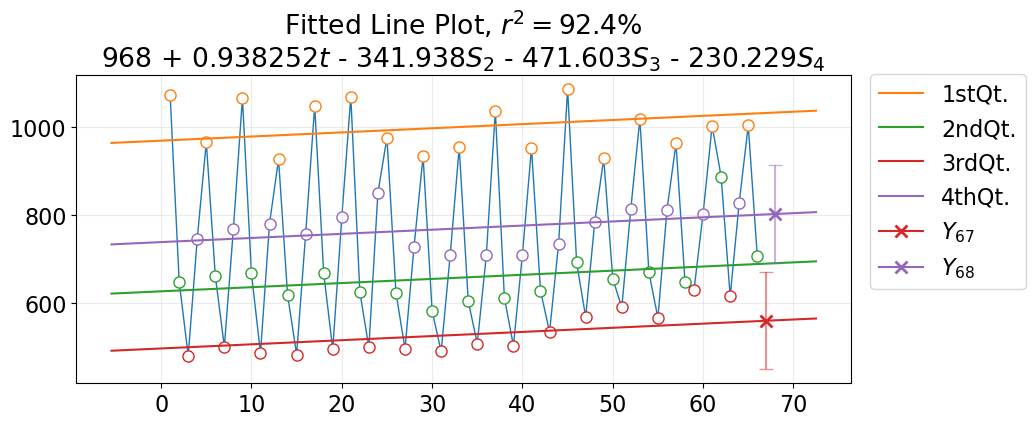

In [199]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_fit["X_1"], df_fit["Y"], 
  linestyle='-', linewidth=1, zorder=0) 

regress = out_dict["regress"]
b_estimate = [regress.intercept_, *regress.coef_]

data_Xt_min = df_fit["X_1"].min()
data_Xt_max = df_fit["X_1"].max()
Xt_offset = 0.1*(data_Xt_max - data_Xt_min)
Xt_regress = np.linspace(data_Xt_min - Xt_offset, data_Xt_max + Xt_offset)

label_arr = ["1stQt.", "2ndQt.", "3rdQt.", "4thQt."]
plot_handler_arr = []
for label, intercept in zip(label_arr, quarter_intercepts):
  plot_handler = ax.plot(Xt_regress, intercept + b_estimate[1]*Xt_regress, 
          linestyle="-", label=label, zorder=2)
  plot_handler_arr.append(plot_handler)

# -- update each data points according its quarter position
q_color_arr = []
for i, plot_handler in enumerate(plot_handler_arr):
  q_color = plot_handler[0]._color
  q_color_arr.append(q_color)

  q_xdata = df_fit["X_1"].iloc[i::4]
  q_ydata = df_fit["Y"].iloc[i::4]
  ax.plot(q_xdata, q_ydata, marker='o', markersize=8, 
    markerfacecolor='white', markeredgecolor=q_color, linestyle="", zorder=1)


# -- add forecasting points
for i, x_regress in enumerate(x_regress_arr):
  ax.plot(x_regress[0], out_dict["fit"][i], color=q_color_arr[(i+2)%4], 
    marker='x', markersize=8, markeredgewidth=2, label=r"$Y_{"+"{:d}".format(x_regress[0])+r"}$")
  
  e_min, e_max = out_dict["prediction_interval"][i]
  ax.errorbar(x_regress[0], out_dict["fit"][i], 
    xerr=None, yerr=[[abs(e_min - out_dict["fit"][i])], [e_max - out_dict["fit"][i]]],
    color=q_color_arr[(i+2)%4], capsize=5, alpha=0.5)

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")

# -- put the estimated parameters below the figure title
label_arr = ["t", "S_2", "S_3", "S_4"]
regress_label = r"{:.0f}".format(b_estimate[0])
for i, label in enumerate(label_arr):
  b_i = b_estimate[i+1]
  regress_label += r" + ${:3g}{:s}$".format(b_i, label)  \
    if b_i > 0 else r" - ${:3g}{:s}$".format(abs(b_i), label)
ax.set_title(r"Fitted Line Plot, $r^2={:.1f}$%".format(out_dict["R_sq"]*100)
  + "\n" + regress_label)

plt.show(fig)

In [180]:
out_dict["prediction_interval"][0]

[449.5367107199538, 669.7644256436824]

Within a given year, forecasts of electrical usage are highest for the first 
quarter, lower for the second quarter, lowest for the third quarter, and second
highest for the fourth quarter.